# Model validation with external data
In this notebook I will try to get the performance of the model on an external dataset I have obtained from a public repository, like ChEMBL, PubChem, Therapeutics Data Commons or MoleculeNet.

I need to find a dataset for which experimental data exactly as the one used to train my model of interest is available.

For this validation of generalizability of the model, from literature/paper, To demonstrate the general performance of the model, we prepared two additional external test sets. The first external test set was from Ryu et al, which contained 30 hERG positives and 14 hERG negatives based on an IC50 threshold of 10 μM. The second external test set was from Siramshetty et al. containing 177 Food and drug adminis- tration (FDA)-approved drugs with two labels. In particu-lar, one label is based on an IC50 threshold of 1 μM, and
the other is based on a threshold of 10 μM.

For our task we will utilize data from the wild, using the hERG Central dataset. it contains three stages, these are three targets: hERG_at_1uM, hERG_at_10uM, and hERG_inhib. 

For our experimental results, we will utilize the hERG_inhib label for binary classification.



In [13]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tdc.utils import retrieve_label_name_list
from tdc.single_pred import Tox
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import inchi
from sklearn.model_selection import train_test_split


current_dir = os.getcwd()
sys.path.append(os.path.abspath("../src"))
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')
Train_csv_path = os.path.join(data_dir, 'training.csv')

from processing import standardise_smiles, generate_inchi_key, standardise_inchikey


In [14]:
# In this code block I will load the external dataset as a pandas data frame

# Load the hERG Central dataset with the 'hERG_inhib' label
data = Tox(name='herg_central', label_name='hERG_inhib').get_data()

df = pd.DataFrame(data)
df.head()
df.info()

# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib.csv')
df.to_csv(save_path, index=False)


Found local copy...
Loading...
Done!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306893 entries, 0 to 306892
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Drug_ID  306893 non-null  int64 
 1   Drug     306893 non-null  object
 2   Y        306893 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.0+ MB


In [15]:
# In this code block I will process the external dataset so that I have a data frame with three columns: standard smiles / InchiKey / experimental_value

# Apply the generate_inchi_key function to create InChiKeys from Drug (SMILES strings)
df['Drug_ID'] = df['Drug'].apply(generate_inchi_key)

# Rename columns to match the expected format
external_data_processed = df.rename(columns={'Drug': 'standard_smiles', 'Drug_ID': 'InchiKey', 'Y': 'experimental_value'})

# Display the first few rows of the processed external dataset
external_data_processed.head()


# Split the dataset into train, validation, and test sets
train_df, test_valid_df = train_test_split(external_data_processed, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Display the shape of each set
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)


# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib_train.csv')
train_df.to_csv(save_path, index=False)

# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib_val.csv')
valid_df.to_csv(save_path, index=False)

# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib_test.csv')
test_df.to_csv(save_path, index=False)


Train set shape: (214825, 3)
Validation set shape: (46034, 3)
Test set shape: (46034, 3)


In [16]:
# In this code block I will make sure there are no repeated molecules between the train set used in the model and the external dataset I curated
# Repeated molecules must be eliminated to avoid bias

# Load the CSV file into a pandas DataFrame
train_df = pd.read_csv(Train_csv_path)

# Display the first few rows of the DataFrame to verify it was loaded correctly
print(train_df.head())

# Apply the function to create InChIKeys from SMILES strings
train_df['InchiKey'] = train_df['smiles'].apply(generate_inchi_key)

print(train_df.head())

# Find common InChIKeys between the training dataset and the external dataset
common_inchi_keys = set(train_df['InchiKey']) & set(external_data_processed['InchiKey'])

# Remove molecules with common InChIKeys from the external dataset
external_data_processed = external_data_processed[~external_data_processed['InchiKey'].isin(common_inchi_keys)]

# Verify that no common molecules exist after removal
common_inchi_keys_updated = set(train_df['InchiKey']) & set(external_data_processed['InchiKey'])
print("Number of common molecules after removal:", len(common_inchi_keys_updated))



              id                                             smiles  label
0  CHEMBL3604797  C=Cc1c(CNC23CCC(CCc4c(F)cnc5ccc(OC)nc45)(CC2)O...      1
1          A3365  C=Cc1c(CN[C@@]23CC[C@@](CCc4c(F)cnc5ccc(OC)nc4...      1
2  CHEMBL3605125  CC(C)(O)CCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5...      1
3  CHEMBL3605143  CC(C)CCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC...      1
4          A1937  CCC(=O)[C@]1(C)Oc2ccc(CN[C@]34CC[C@](CCc5c(F)c...      1
              id                                             smiles  label  \
0  CHEMBL3604797  C=Cc1c(CNC23CCC(CCc4c(F)cnc5ccc(OC)nc45)(CC2)O...      1   
1          A3365  C=Cc1c(CN[C@@]23CC[C@@](CCc4c(F)cnc5ccc(OC)nc4...      1   
2  CHEMBL3605125  CC(C)(O)CCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5...      1   
3  CHEMBL3605143  CC(C)CCOc1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC...      1   
4          A1937  CCC(=O)[C@]1(C)Oc2ccc(CN[C@]34CC[C@](CCc5c(F)c...      1   

                      InchiKey  
0  JSEMNTBLXZENFJ-UHFFFAOYSA-N  
1  JSEMNTBLXZEN

# Model validation with external data- spliiting the dataset
The external data set from HERG central consists of 309893 molecules.Thats quite a large number even though the authors pretrained a bayesian graph neural network with 300,000 molecules as a transfer learning exercise.

I split the dataset into ;

Train set shape: (214825, 3)

Validation set shape: (46034, 3)

Test set shape: (46034, 3)

I tried to make predictions with the training set , but unfortunately it could not completed the predictions as it takes forever.

So i had to split the validation set into; 0.5 but still the 46034 molecules took endless time to finish predictions of the eos4tcc model.

Finally, I curated to a 1000 molecule validation data set and I went ahead to make the predictions.
This was successful and I will go ahead to load the predictions.





In [17]:
#This code block above  confirms that there is no data leakage, as molecules from the external dataset are not present in the training dataset used for the model.


# predictions I obtained with the EMH model

# Further split the validation set into smaller subsets
valid_df_1, valid_df_2 = train_test_split(valid_df, test_size=1000, random_state=42)

# Display the shape of each subset
print("Validation set 1 shape:", valid_df_1.shape)
print("Validation set 2 shape:", valid_df_2.shape)

# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib_valid1.csv')
valid_df_1.to_csv(save_path, index=False)

# Save the filtered DataFrame to a CSV file in the data directory
save_path = os.path.join(data_dir, 'herg_central_hERG_inhib_valid2.csv')
valid_df_2.to_csv(save_path, index=False)

valid_df_2.head()


Validation set 1 shape: (45034, 3)
Validation set 2 shape: (1000, 3)


,InchiKey,standard_smiles,experimental_value
81934,YQOXEFMWVBLDBI-UHFFFAOYSA-N,Cc1cccc(Nc2nc(N)c([N+](=O)[O-])c(NCc3ccco3)n2)c1,0
17109,MRQFOZLKBCTFQB-UHFFFAOYSA-N,COc1ccc(C(=O)N2CCCCCC2)cc1OC1CCN(C(C)=O)CC1,0
113491,FNNSJXWEFTXZSZ-UHFFFAOYSA-N,COc1cccc(NC(=S)N(CCc2c(C)[nH]c3ccc(C)cc23)Cc2c...,0
64892,XIMYFKZWRYQNAU-UHFFFAOYSA-N,Cc1cccc2c1N(C(=O)c1ccco1)C(C)(C)c1ssc(=S)c1-2,0
218440,OZXFFUIKJOFURU-UHFFFAOYSA-N,Cc1nc(SCC(=O)Nc2cc(S(=O)(=O)N3CCOCC3)ccc2Cl)nc...,0


In [5]:
# In this codeblock I will load the predictions I obtained with the EMH model and check several ML performance metrics

valid2_prediction_csv_path = os.path.join(data_dir, 'herg_central_hERG_inhib_valid2prediction.csv')

# Load the predictions into a DataFrame
predictions_df = pd.read_csv(valid2_prediction_csv_path)

# verify it was loaded correctly
print(predictions_df.head())


                           key  \
0  YQOXEFMWVBLDBI-UHFFFAOYSA-N   
1  MRQFOZLKBCTFQB-UHFFFAOYSA-N   
2  FNNSJXWEFTXZSZ-UHFFFAOYSA-N   
3  XIMYFKZWRYQNAU-UHFFFAOYSA-N   
4  OZXFFUIKJOFURU-UHFFFAOYSA-N   

                                               input     score      alea  \
0   Cc1cccc(Nc2nc(N)c([N+](=O)[O-])c(NCc3ccco3)n2)c1  0.159002  0.122146   
1        COc1ccc(C(=O)N2CCCCCC2)cc1OC1CCN(C(C)=O)CC1  0.158522  0.121699   
2  COc1cccc(NC(=S)N(CCc2c(C)[nH]c3ccc(C)cc23)Cc2c...  0.164358  0.125733   
3      Cc1cccc2c1N(C(=O)c1ccco1)C(C)(C)c1ssc(=S)c1-2  0.170632  0.128344   
4  Cc1nc(SCC(=O)Nc2cc(S(=O)(=O)N3CCOCC3)ccc2Cl)nc...  0.159625  0.123130   

       epis  
0  0.011575  
1  0.011694  
2  0.011612  
3  0.013173  
4  0.011015  


AUC = 0.491 ± 0.043


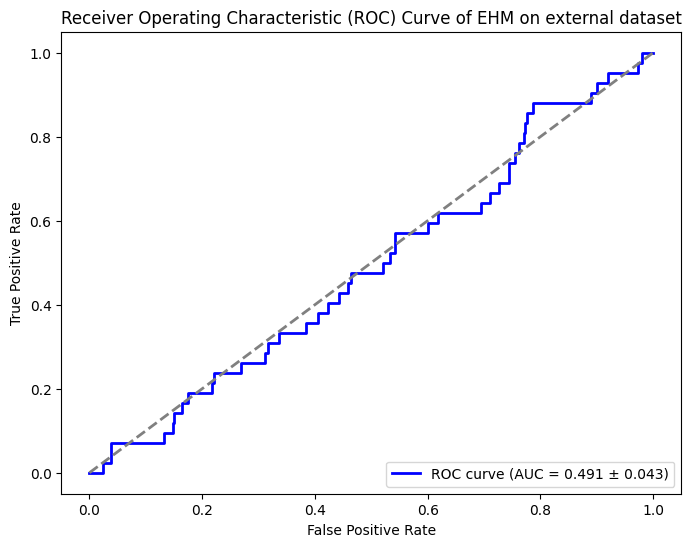

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt


# Extract true labels and predicted scores
y_true = valid_df_2['experimental_value']  # True labels
y_score = predictions_df['score']  # Predicted scores from your model

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Compute ROC-AUC score
auc = roc_auc_score(y_true, y_score)

# Bootstrap to compute confidence interval for AUC
n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(y_true), len(y_true), replace=True)
    auc_values[i] = roc_auc_score(y_true.iloc[indices], y_score.iloc[indices])

# Calculate standard error of AUC
auc_std_error = np.std(auc_values)

# Print AUC with standard error
print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of EHM on external dataset')
plt.legend(loc='lower right')
plt.show()


# deduction of Receiver Operating Characteristic (ROC) Curve of EHM on external dataset
while the model shows some capability in predicting hERG channel blockade, its performance, as indicated by the ROC-AUC score, suggests that there is room for improvement to make it more reliable and useful for practical applications





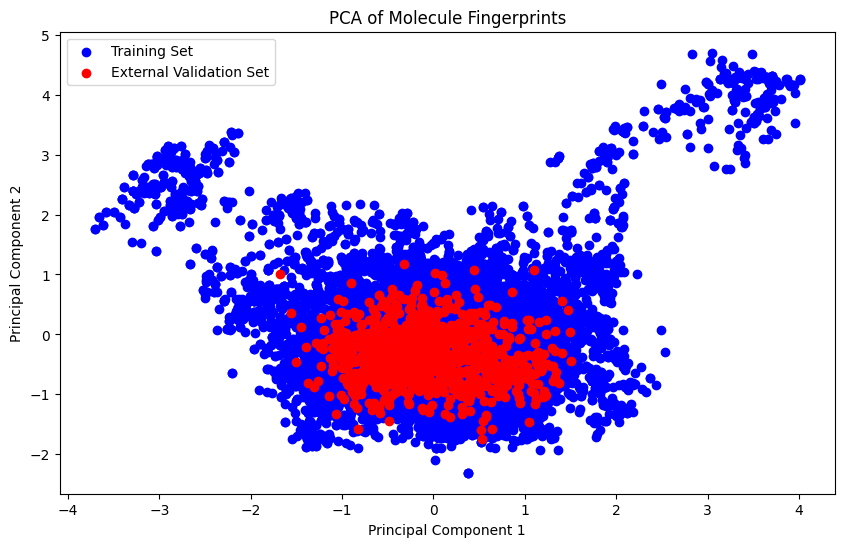

In [22]:
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import numpy as np

# Function to generate Morgan fingerprints
def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(fingerprint)
        else:
            fingerprints.append(None)
    return fingerprints

# Generate Morgan fingerprints for the training set
train_morgan_fps = generate_morgan_fingerprints(train_df['smiles'])

# Generate Morgan fingerprints for the external validation set
valid2_morgan_fps = generate_morgan_fingerprints(valid_df_2['standard_smiles'])

# Remove None values from the lists
train_morgan_fps = [fp for fp in train_morgan_fps if fp is not None]
valid2_morgan_fps = [fp for fp in valid2_morgan_fps if fp is not None]

# Convert Morgan fingerprints to numpy arrays
train_morgan_fps_array = np.array(train_morgan_fps)
valid2_morgan_fps_array = np.array(valid2_morgan_fps)

# Apply PCA to the training set and external validation set
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_morgan_fps_array)
valid2_pca = pca.transform(valid2_morgan_fps_array)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c='blue', label='Training Set')
plt.scatter(valid2_pca[:, 0], valid2_pca[:, 1], c='red', label='External Validation Set')
plt.title('PCA of Molecule Fingerprints')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# deducton on the PCA of Molecule Fingerprints
the two sets are set overlap or are closely clustered together,which suggests that the two sets have similar chemical properties or are located in similar regions of chemical space. at the same time some points are quite distinct which may on the other hand show abit of different chemical space. 

Quantifying this would be a better choice to get the real numbers and decide whether overlap or not
